# Exploratory data analysis on the San Francisco 311 data
Data can be downloaded from: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6/data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

## The time window to bucket samples
TIME_RANGE = '24H'

## File path (original data is ~1GB, this is a reduced version with only categories and dates)
#Original file:
#DATAPATH = "SF311_simplified.csv"

#Sample raw data:
DATAPATH = "SF_data/SF-311_simplified.csv"

### Read sample of data (original data contains additional columns)

In [2]:
raw_sample = pd.read_csv(DATAPATH, nrows=5)
raw_sample.head()

,Unnamed: 0,Opened,Category,Request Details
0,0,07/02/2008 03:16:55 PM,Tree Maintenance,Lifted_sidewalk_tree_roots
1,1,07/02/2008 04:47:08 PM,Tree Maintenance,Hanging_limb
2,2,07/02/2008 05:54:07 PM,Tree Maintenance,Blocking_street_lights
3,3,07/03/2008 12:38:04 PM,Tree Maintenance,Sprinkler_system_issues
4,4,07/03/2008 12:44:26 PM,Street and Sidewalk Cleaning,Other Loose Garbage


In [3]:
raw = pd.read_csv(DATAPATH).drop(columns='Unnamed: 0')
raw.head(20)

,Opened,Category,Request Details
0,07/02/2008 03:16:55 PM,Tree Maintenance,Lifted_sidewalk_tree_roots
1,07/02/2008 04:47:08 PM,Tree Maintenance,Hanging_limb
2,07/02/2008 05:54:07 PM,Tree Maintenance,Blocking_street_lights
3,07/03/2008 12:38:04 PM,Tree Maintenance,Sprinkler_system_issues
4,07/03/2008 12:44:26 PM,Street and Sidewalk Cleaning,Other Loose Garbage
5,07/03/2008 01:24:07 PM,Tree Maintenance,Lifted_sidewalk_tree_roots
6,07/07/2008 03:14:07 PM,Tree Maintenance,Near_communication_line
7,07/08/2008 06:25:18 PM,Tree Maintenance,About_to_fall
8,07/09/2008 02:57:52 PM,Tree Maintenance,Near_communication_line
9,07/09/2008 04:57:24 PM,Tree Maintenance,Near_communication_line


#### Initial data prep

In [4]:
## Rename columns
raw = raw.rename(columns={'Opened': 'date', 'Category': 'category'})

## Turn the raw data into a time series (with date as DatetimeIndex)
from moda.dataprep.raw_to_ts import raw_to_ts
ts = raw_to_ts(raw,date_format="%m/%d/%Y %H:%M:%S %p")

In [6]:
ts.head()

,category,Request Details,timestamp
date,,,
2008-07-02 03:16:55,Tree Maintenance,Lifted_sidewalk_tree_roots,1214968615
2008-07-02 04:47:08,Tree Maintenance,Hanging_limb,1214974028
2008-07-02 05:54:07,Tree Maintenance,Blocking_street_lights,1214978047
2008-07-03 12:38:04,Tree Maintenance,Sprinkler_system_issues,1215088684
2008-07-03 12:44:26,Street and Sidewalk Cleaning,Other Loose Garbage,1215089066


In [7]:
## Some general stats

print("Dataset length: " + str(len(ts)))
print("Min date: " + str(ts.index.get_level_values('date').min()))
print("Max date: " + str(ts.index.get_level_values('date').max()))

print("Total time: {}".format(ts.index.get_level_values('date').max() - ts.index.get_level_values('date').min()))

print("Dataset contains {} categories.".format(len(ts['category'].unique())))



Dataset length: 3133199
Min date: 2008-07-01 01:00:00
Max date: 2018-08-25 12:36:54
Total time: 3707 days 11:36:54
Dataset contains 102 categories.


#### Next, we decide on the time interval and aggregate items per time and category

In [8]:
TIME_RANGE ='1H'
from moda.dataprep.ts_to_range import ts_to_range
ranged_ts = ts_to_range(ts,time_range=TIME_RANGE)
ranged_ts.tail(20)

value
date                category                             
2018-08-24 12:00:00 Abandoned Vehicle                   4
                    Damaged Property                    6
                    General Request - COUNTY CLERK      1
                    General Request - DPH               2
                    General Request - MTA               1
                    General Request - PUBLIC WORKS      8
                    General Request - PUC               1
                    General Request - SFPD              1
                    Graffiti                            5
                    Litter Receptacles                  1
                    MUNI Feedback                      10
                    Noise Report                        1
                    SFHA Requests                       1
                    Sewer Issues                        4
                    Sidewalk or Curb                    2
                    Temporary Sign Request              1
2018-08-25 12:00:00 General Request - PUBLIC WORKS      1
                    MUNI Feedback                       1
                    Noise Report                        1
                    Sign Repair                         1

In [9]:
#I'm using dfply because I like its functional-like syntax. This can also be done with plain pandas.
#!pip install dfply
from dfply import *

## Remove categories with less than 1000 items (in more than 10 years) or that existed less than 100 days
min_values = 1000
min_days = 100



categories = ranged_ts.reset_index() >> group_by(X.category) >> \
    summarise(value = np.sum(X.value),duration_in_dataset = X.date.max()-X.date.min()) >> \
    ungroup() >> \
    mask(X.duration_in_dataset.dt.days > min_days) >> \
    mask(X.value > min_values) >> \
    arrange(X.value,ascending=False)



print("Filtered dataset contains {0} categories,\nafter filtering the small ones that existed less than {1} days or had {2} values of less.".
      format(len(categories),min_days,min_values))

categories.head()

Filtered dataset contains 46 categories,
after filtering the small ones that existed less than 100 days or had 1000 values of less.


,category,value,duration_in_dataset
98,Street and Sidewalk Cleaning,869024,3705 days 11:00:00
83,Graffiti,457827,3706 days 10:00:00
88,MUNI Feedback,198420,3373 days 11:00:00
1,Abandoned Vehicle,194940,3706 days 11:00:00
84,Homeless Concerns,160384,3700 days 00:00:00


### Most common categories

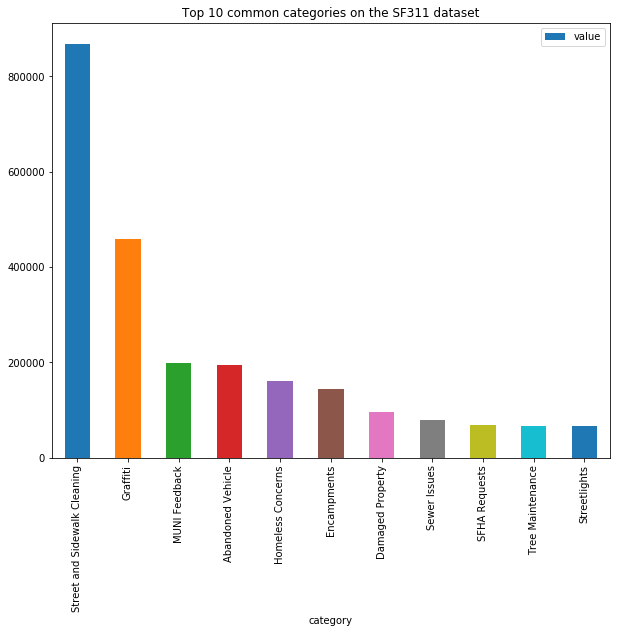

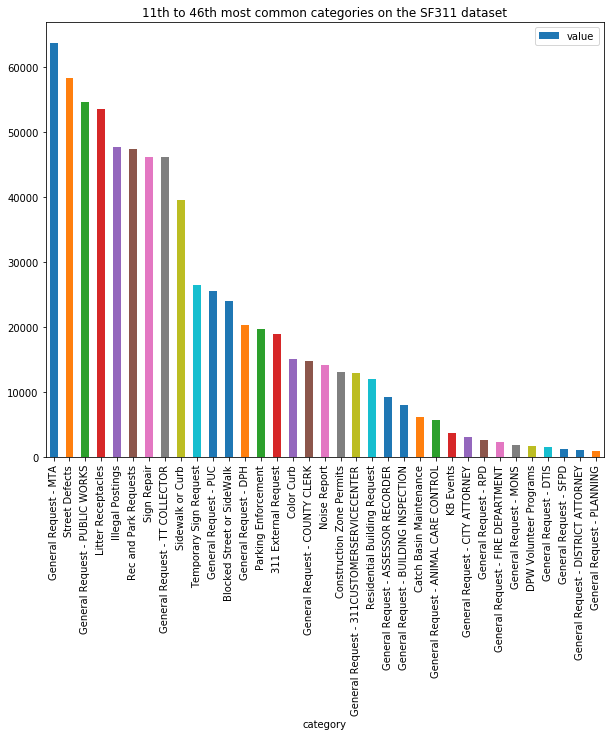

In [10]:
category_names = categories['category'].values
num_categories = len(categories)

major_category_threshold=11
major_categories = category_names[:major_category_threshold]
minor_categories = category_names[major_category_threshold:]


categories[categories['category'].isin(major_categories)].plot(kind='bar',x='category',y='value',title="Top "+str(major_category_threshold-1)+" common categories on the SF311 dataset",figsize=(10,8))
categories[categories['category'].isin(minor_categories)].plot(kind='bar',x='category',y='value',title=str(major_category_threshold)+"th to "+str(num_categories)+"th most common categories on the SF311 dataset",figsize=(10,8))

### Change in requests per category from year to year

Text(0.5,1,'Yearly number of incidents for the top 10 categories')

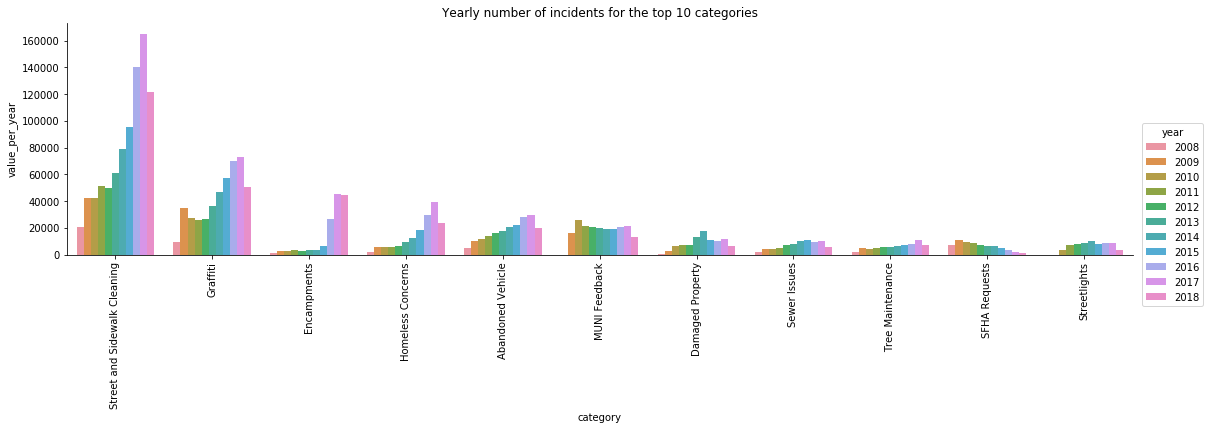

In [11]:
## Calculate the number of values per category per year
categories_yearly = ranged_ts.reset_index() >> mutate(year = X.date.dt.year) >> group_by(X.category,X.year) >> \
    summarise(value_per_year = np.sum(X.value),
              duration_in_dataset = X.date.max()-X.date.min()) >>\
    ungroup() >> \
    mask(X.value_per_year > (min_values/12.0)) >> \
    arrange(X.value_per_year,ascending=False)

import seaborn as sns

major_cats_yearly = categories_yearly[categories_yearly['category'].isin(major_categories)]

g = sns.factorplot(x='category', y='value_per_year', hue='year', data=major_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the top "+str(major_category_threshold-1)+" categories")

Text(0.5,1,'Yearly number of incidents for the 11th to 46th categories')

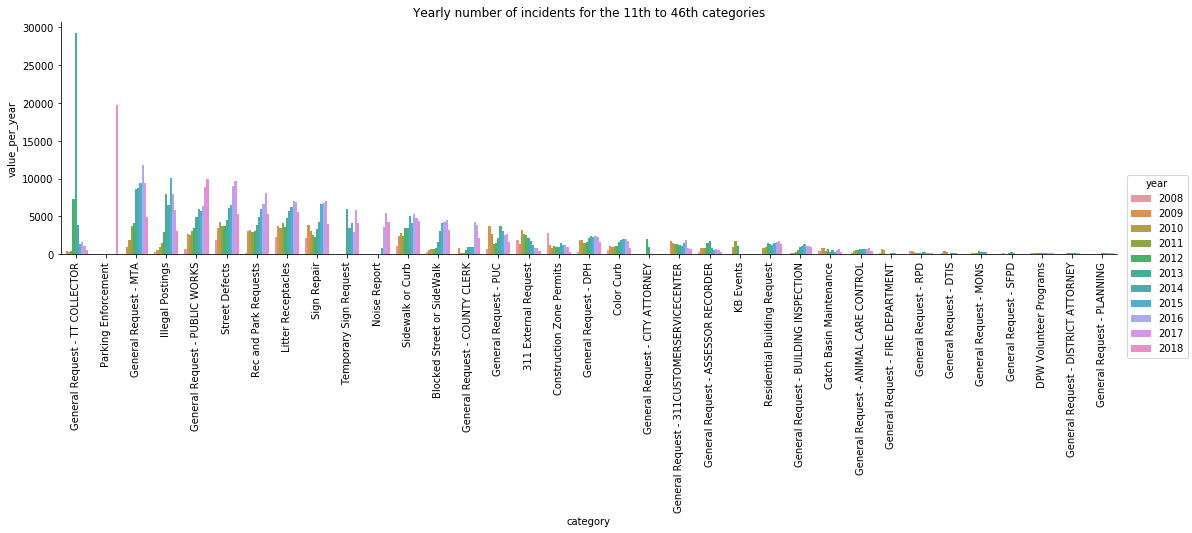

In [12]:
minor_cats_yearly = categories_yearly[categories_yearly['category'].isin(minor_categories)]

g = sns.factorplot(x='category', y='value_per_year', hue='year', data=minor_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the "+str(major_category_threshold)+"th to "+str(num_categories)+"th categories")

### Correlation between categories over time

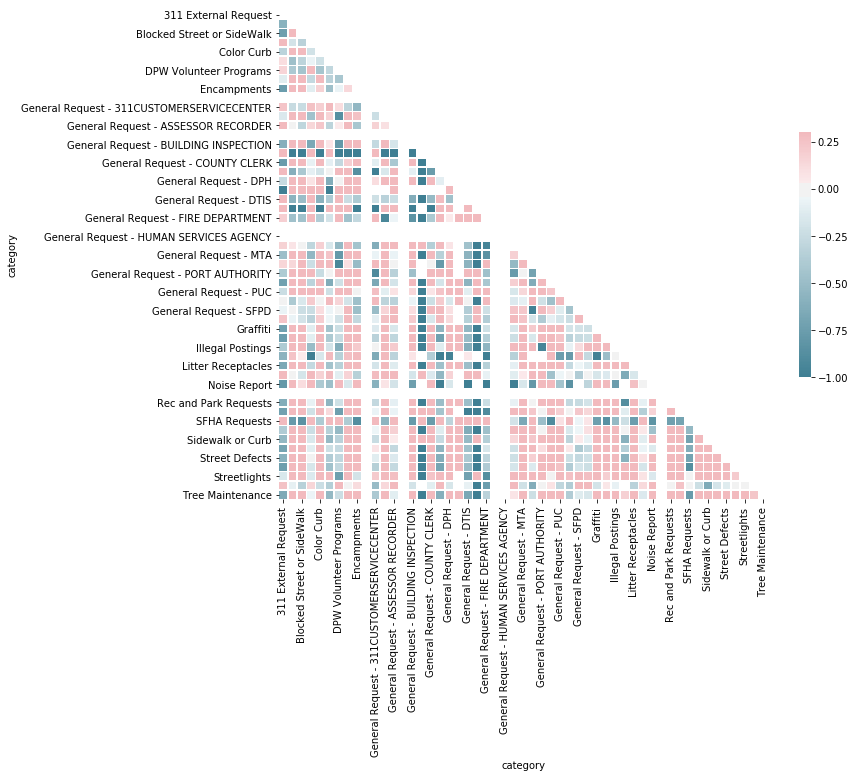

In [13]:
categories_yearly_pivot = categories_yearly.pivot("year", "category", "value_per_year")
categories_yearly_pivot.head()
corr = categories_yearly_pivot.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### One category inspection

In [14]:
street_cleaning = ranged_ts.loc[pd.IndexSlice[:, 'Street and Sidewalk Cleaning'], :].reset_index(level='category', drop=True)
street_cleaning.head()

,value
date,
2008-07-01 01:00:00,13
2008-07-01 02:00:00,14
2008-07-01 03:00:00,6
2008-07-01 04:00:00,11
2008-07-01 05:00:00,13


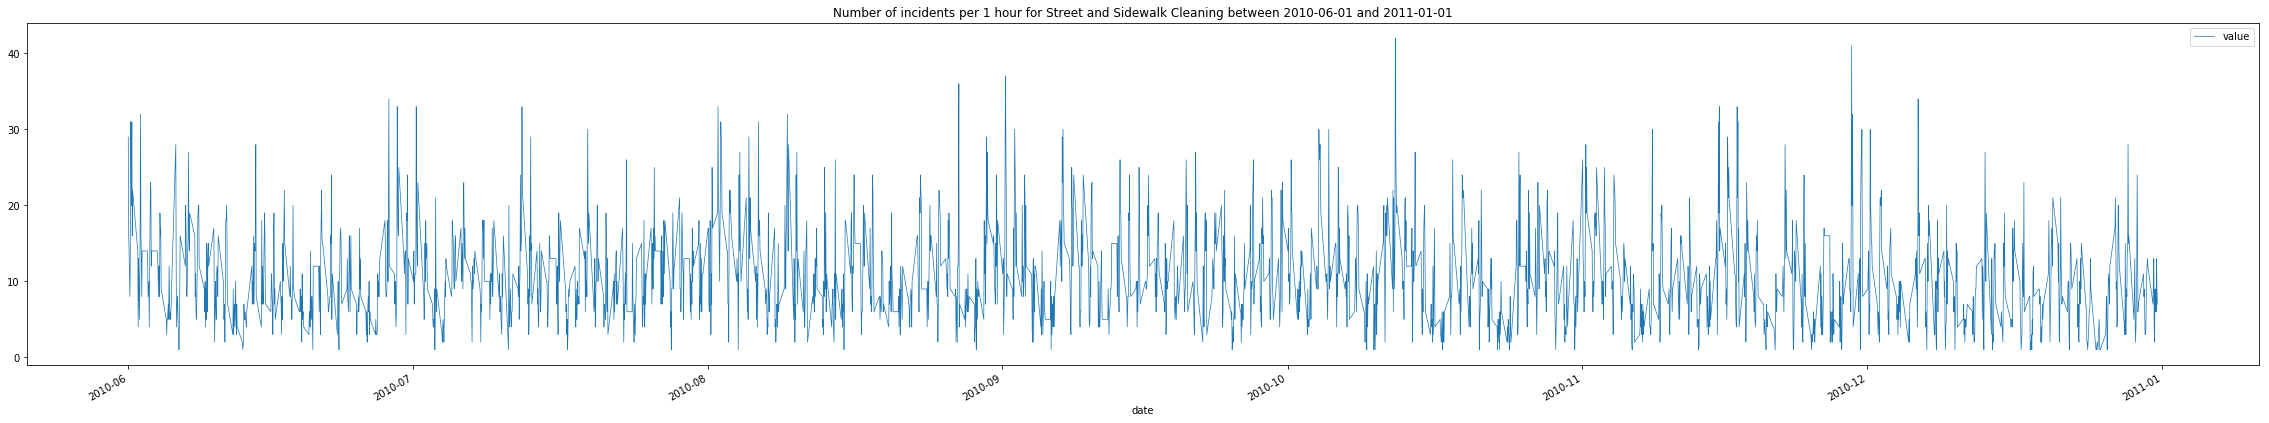

In [16]:
START = '2010-06-01'
END = '2011-01-01'
street_cleaning_flat = street_cleaning.reset_index()
street_cleaning_flat = street_cleaning_flat[(street_cleaning_flat['date'] > START) & (street_cleaning_flat['date']<=END)]
street_cleaning_flat.plot(kind='line',x='date',y='value',figsize=(40,7),linewidth=0.7, 
                          title = "Number of incidents per 1 hour for Street and Sidewalk Cleaning between {0} and {1}".format(START,END))

## Evaluating different models on the SF 24H data

In [20]:
from moda.evaluators import get_metrics_for_all_categories, get_final_metrics
from moda.evaluators.eval_all_models import eval_all_models
from moda.models.azure_anomaly_detection.azure_ad import AzureAnomalyTrendinessDetector
from moda.models.data_reader import read_data
from moda.models.ma_seasonal.ma_seasonal_model import MovingAverageSeasonalTrendinessDetector
from moda.models.stl.stl_model import STLTrendinessDetector
from moda.models.twitter.anomaly_detect_multicategory import TwitterAnomalyTrendinessDetector


def run_model(datapath, freq, min_date='01-01-2018', plot=True, model_name='stl', min_value=10,
              min_samples_for_category=100):
    print("Loading file {0}, with frequency {1}. Model name = {2}".format(datapath, freq, model_name))
    dataset = read_data(datapath, min_date=min_date)
    dataset = dataset.rename(columns={'is_anomaly': 'label'})

    if model_name == 'twitter':
        model = TwitterAnomalyTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value, threshold=None,
                                                 max_anoms=0.49, seasonality_freq=7)

    if model_name == 'ma_seasonal':
        model = MovingAverageSeasonalTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value,
                                                        anomaly_type='or',
                                                        num_of_std=3)

    if model_name == 'stl':
        model = STLTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value,
                                      anomaly_type='or',
                                      num_of_std=2.5, lo_delta=0)

 
    prediction = model.predict(dataset, verbose=True)
    raw_metrics = get_metrics_for_all_categories(dataset[['value']], prediction[['prediction']], dataset[['label']],
                                                 window_size_for_metrics=5)
    metrics = get_final_metrics(raw_metrics, summarized=True)
    print(metrics)

    ## Plot each category
    if plot:
        _, file = os.path.split(datapath)
        print("Plotting...")
        model.plot(labels=dataset['label'], postfix=file)

    return prediction